In [1]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

# see also https://quantumcomputing.stackexchange.com/questions/29007/solve-sudoku-using-grovers-algorithm 

import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

In [3]:
%pip install qiskit_aer

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.5 MB 1.1 MB/s eta 0:00:09
    --------------------------------------- 0.2/9.5 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.2/9.5 MB 1.0 MB/s eta 0:00:09
   - -------------------------------------- 0.3/9.5 MB 1.4 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/9.5 MB 1.8 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/9.5 MB 2.2 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/9.5 MB 2.2 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/9.5 MB 2.3 MB/s eta 0:00:04
   ---- ----------------------------------- 1.2/9.5 MB 2.5 MB/s eta 0:00:04
   ----- ---------------------------------- 1.3/9.5 MB 2.6 MB/s eta 0:00:04
   ----- ------------------------


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: C:\Users\Ted Hromadka\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np

import qiskit
#from qiskit import IBMQ, Aer, transpile, execute
from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
#from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library.standard_gates import XGate, ZGate
#from qiskit.circuit.library import MCMT
#from qiskit.circuit.library.generalized_gates import MCMTGate

from qiskit_aer import AerSimulator


# import basic plot tools
from qiskit.visualization import plot_histogram


qiskit.version.get_version_info()

'1.1.0'

In [5]:
#from qiskit_textbook.problems import grover_problem_oracle
### Example Usage
#n = 4
#oracle = grover_problem_oracle(n, variant=1)  # 0th variant of oracle, with n qubits
#qc = QuantumCircuit(n)
#qc.append(oracle, [0,1,2,3])
#qc.draw()

In [6]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [7]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [8]:
def diffuser(nqubits):
    qcirc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qcirc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qcirc.x(qubit)
    # Do multi-controlled-Z gate
    qcirc.h(nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    c3z = ZGate().control(num_ctrl_qubits=3, ctrl_state='111')
    qcirc.append(c3z, [0,1,2,3])
    # this will support the call: qc.append(diffuser(4), [0,1,2,3])


    qcirc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qcirc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qcirc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qcirc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [9]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
           │       
input_1: ──┼────■──
         ┌─┴─┐┌─┴─┐
 output: ┤ X ├┤ X ├
         └───┘└───┘

In [10]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

In [11]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
# MCT = multi-controlled Toffoli gate
#qc.mct(clause_qubits, output_qubit)
#qc.MCMTGate(XGate(), len(clause_qubits), len(output_qubit))
c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
qc.append(c3z, [4,5,6,7,8])

qc.draw()

v_0: ──■─────────■──────────────────────────────
       │         │                              
v_1: ──┼────■────┼─────────■────────────────────
       │    │    │         │                    
v_2: ──┼────┼────┼────■────┼─────────■──────────
       │    │    │    │    │         │          
v_3: ──┼────┼────┼────┼────┼────■────┼────■─────
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │     
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───■─
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   │ 
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼───■─
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │   │ 
c_2: ────────────────────┤ X ├┤ X ├──┼────┼───■─
                         └───┘└───┘┌─┴─┐┌─┴─┐ │ 
c_3: ──────────────────────────────┤ X ├┤ X ├─■─
                                   └───┘└───┘ │ 
out: ─────────────────────────────────────────■─

In [12]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
   #qc.mct(clause_qubits, output_qubit)
    c3z = ZGate().control(num_ctrl_qubits=4, ctrl_state='1111')
    qc.append(c3z, [4,5,6,7,8])


    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()


»
    v_0: ──■─────────■────────────────────────────────■─────────■────────────»
           │         │                                │         │            »
    v_1: ──┼────■────┼─────────■──────────────────────┼────■────┼─────────■──»
           │    │    │         │                      │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │            │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■───────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │     ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───■─┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   │ └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼───■───────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │   │           └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼───■─────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐ │                     └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├─■──────────────────────────»
                                       └───┘└───┘ │                          »
    out: ─────────────────────────────────────────■──────────────────────────»
                                                                             »
cbits: 4/════════════════════════════════════════════════════════════════════»
                                                                             »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«    out: ───────────────
«                        
«cbits: 4/═══════════════
«

In [13]:
# full algorithm

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                     ░ ┌────────┐                                                                                    ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                │         │                            ░ │        │  │         │                                │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■──────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■──────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                      │    │    │         │                  ░ │  U$_s$ │  │    │    │         │                      │    │    │         │                  ░ │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │            │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │            │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■───────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■───────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───■─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───■─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   │ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   │ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼───■───────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼───■───────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │   │           └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │   │           └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼───■─────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼───■─────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐ │                     └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐ │                     └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├─■───────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├─■───────────────────────────────┤ X ├┤ X ├─░────────────╫──╫──╫──╫─
         ┌────────────────────────────

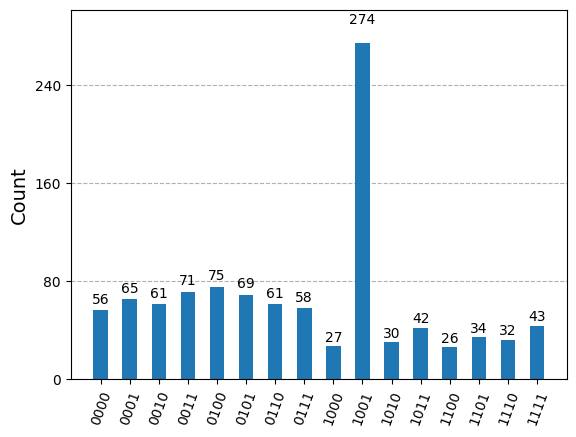

In [14]:
# Simulate and plot results
simulator = AerSimulator() #qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc =  transpile(qc, simulator) #transpiled_qc = transpile(qc, qasm_simulator)
result = simulator.run(transpiled_qc).result() #result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())